## Import Semua Packages/Library yang Digunakan

In [ ]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq # untuk menampilkna bar progres saat proses iterasi

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Import the required library
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image, ImageDraw, ImageOps
import seaborn as sns
from google.colab import files

In [ ]:
# Untuk menonaktifkan warinig yang mungkin muncul, seperti FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


In [ ]:
# Menggunakan Google Colab
!nvidia-smi

Tue May 20 06:40:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Data Preparation

### Data Loading

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bustanulkhair","key":"59214902db599e3f755fb1e9cf36c965"}'}

In [ ]:
# Buat direktori jika belum ada

os.makedirs("/root/.kaggle", exist_ok=True)

# Pindahkan file ke direktori .kaggle

shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Atur permission agar tidak terlalu terbuka

os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
!kaggle datasets download cookiefinder/tomato-disease-multiple-sources

Dataset URL: https://www.kaggle.com/datasets/cookiefinder/tomato-disease-multiple-sources
License(s): CC0-1.0
100% 1.37G/1.37G [00:11<00:00, 254MB/s]
100% 1.37G/1.37G [00:11<00:00, 124MB/s]


In [ ]:
!unzip tomato-disease-multiple-sources.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/Late_blight/9afc2537-1b13-4c25-b5ed-5b8de511b0ab___GHLB2 Leaf 9033.JPG  
  inflating: valid/Late_blight/9bb49d22-976d-40c3-bc9a-bff5cbbd8e28___RS_Late.B 5057.JPG  
  inflating: valid/Late_blight/9c274db5-2f89-4f3c-b9e2-4d5ebc54ddad___GHLB2 Leaf 9096.JPG  
  inflating: valid/Late_blight/9c726f4e-045b-4080-b53d-d7e66d45bcb1___RS_Late.B 4876.JPG  
  inflating: valid/Late_blight/9e5dd34f-124c-4a64-ba9f-77c8d05faa9c___GHLB2 Leaf 8749.JPG  
  inflating: valid/Late_blight/9e633823-3dde-450c-8172-733021e4dff0___RS_Late.B 6414.JPG  
  inflating: valid/Late_blight/9ecb8001-2f48-4487-b287-535dbcfb5c2f___RS_Late.B 6206.JPG  
  inflating: valid/Late_blight/9f7dcd60-e691-4c1e-830e-7495f7cc123d___RS_Late.B 6166.JPG  
  inflating: valid/Late_blight/Bacterial_spots2276_jpg.rf.5becd3793ec2a532bf8f111d60911c63.jpg  
  inflating: valid/Late_blight/IMG_1526_jpg.rf.5e25005985e2b12a6f52bfa7120f3eee.jpg  
  inflating: valid/Late_blight/IMG_

### Dataset Checking


In [ ]:
import os
import shutil

In [ ]:
# Direktori awal untuk train dan test
train_dir = 'train'
test_dir = 'valid'

# Direktori baru untuk dataset gabungan
combined_dir = "Tomato-Disease/dataset"

In [ ]:
# direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Daftar kelas penyakit daun non-parasit
leaf_disease_class = [
    "Bacterial_spot",
    "Early_blight",
    "Late_blight",
    "Leaf_Mold",
    "Septoria_leaf_spot",
    "Target_Spot",
    "healthy",
    "powdery_mildew"
]

# Salin folder dari train_dir
for category in os.listdir(train_dir):
    if category in leaf_disease_class:
        category_dir = os.path.join(train_dir, category)
        if os.path.isdir(category_dir):
            shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin folder dari test_dir
for category in os.listdir(test_dir):
    if category in leaf_disease_class:
        category_dir = os.path.join(test_dir, category)
        if os.path.isdir(category_dir):
            shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [ ]:
path = 'Tomato-Disease/dataset'
rice_image = {}

# Hanya ambil folder (class) yang valid
for i in os.listdir(path):
    class_path = os.path.join(path, i)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        rice_image[i] = images

# menampilkan secara acak 5 gambar di bawah setiap kelas dari data
path_sub = "Tomato-Disease/dataset"

# menampilkan secarak acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(rice_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(rice_image.keys()):
    images = rice_image[class_name]

    if len(images) >= 5:
        sampled_images = np.random.choice(images, 5, replace=False)
    else:
        print(f"[WARNING] Kelas '{class_name}' hanya memiliki {len(images)} gambar. Menampilkan semua.")
        sampled_images = images + [''] * (5 - len(images))  # padding kosong agar tidak error

    for j, image_name in enumerate(sampled_images):
        ax = axs[i, j]
        if image_name != '':
            img_path = os.path.join(path, class_name, image_name)
            img = Image.open(img_path)
            ax.imshow(img)
        ax.set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

### Plot Distribusi

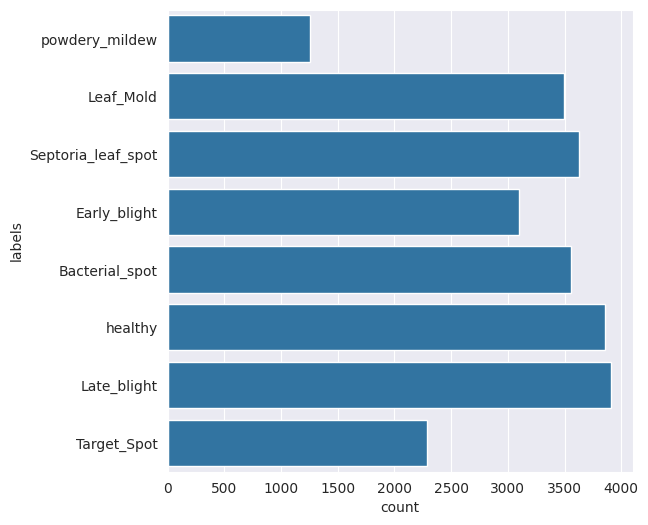

In [ ]:
# path sumber
tomato_path = 'Tomato-Disease/dataset'

# daftar untuk menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path=[]

# mengambil file gamber, path file, dan label
for path, subdirs, files in os.walk(tomato_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, 'labels':labels})

# plot distribusi
Label = distribution_train['labels']
plt.figure(figsize = (6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Data Augmentation

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import numpy as np
# import random
# from skimage.transform import resize
# from skimage.filters import gaussian
# from skimage import img_as_float

# # Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
# def anticlockwise_rotation(img):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
#     return img

# # Membuat fungsi untuk melakukan rotasi searah jarum jam
# def clockwise_rotation(img):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
#     return img

# # Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
# def flip_up_down(img):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.flip_up_down(img)
#     return img

# # Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
# def add_brightness(img):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
#     return img

# # Membuat fungsi untuk memberikan efek blur pada gambar
# def blur_image(img):
#     img = resize(img, (224, 224), preserve_range=True)
#     img = img_as_float(img)  # pastikan nilainya antara 0 dan 1
#     img = gaussian(img, sigma=1, channel_axis=-1)  # jika RGB, pastikan channel_axis benar
#     return img

# # Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
# def sheared(img):
#     img = tf.image.resize(img, (224, 224))
#     # Buat objek ImageDataGenerator dengan parameter shearing range
#     datagen = ImageDataGenerator(shear_range=0.2)
#     img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
#     return img

# # Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
# def warp_shift(img):
#     img = tf.image.resize(img, (224, 224))
#     # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
#     datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
#     img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
#     return img

In [ ]:
# transformations = {
#     'rotate anticlockwise': anticlockwise_rotation,
#     'rotate clockwise': clockwise_rotation,
#     'warp shift': warp_shift,
#     'blurring image': blur_image,
#     'add brightness': add_brightness,
#     'flip up down': flip_up_down,
#     'shear image': sheared
# }

# images_path = "tomato_disease/dataset/powdery_mildew"  # Path for the original image
# augmented_path = "tomato_disease/dataset/powdery_mildew_augmented"  # Path to put the augmented image
# images = []  # To save images that have been preprocessed from the folder

# # Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
# for im in os.listdir(images_path):
#     images.append(os.path.join(images_path, im))

# # Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
# images_to_generate = 2000
# i = 1

# while i <= images_to_generate:
#     image = random.choice(images)
#     try:
#         original_image = io.imread(image)

#         # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
#         if original_image.ndim not in [3, 4]:
#             raise ValueError('Invalid image dimensions')

#         transformed_image = None
#         n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
#         transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

#         while n <= transformation_count:
#             key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
#             transformed_image = transformations[key](original_image)
#             n = n + 1

#         new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
#         transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
#         cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
#         i = i + 1
#     except ValueError as e:
#         print('Could not read or process the image', image, ':', e, 'hence skipping it.')

In [ ]:
# # Define source path
# tomato_path = "tomato_disease/dataset/"

# # Create a list that stores data for each filenames, filepaths, and labels in the data
# file_name = []
# labels = []
# full_path = []

# # Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
# for path, subdirs, files in os.walk(tomato_path):
#     for name in files:
#         full_path.append(os.path.join(path, name))
#         labels.append(path.split('/')[-1])
#         file_name.append(name)

# distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# # Plot the distribution of images across the classes
# Label = distribution_train['labels']
# plt.figure(figsize = (6,6))
# sns.set_style("darkgrid")
# plot_data = sns.countplot(Label)

#### Split Dataset

In [ ]:
mypath = 'Tomato-Disease'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

df = pd.DataFrame({'path':full_path, 'file_name':file_name, 'labels':labels})
df.groupby(['labels']).size()

,0
labels,
Bacterial_spot,3558
Early_blight,3098
Late_blight,3905
Leaf_Mold,3493
Septoria_leaf_spot,3628
Target_Spot,2284
healthy,3857
powdery_mildew,1256


In [ ]:
X = df['path']
y = df['labels']

# Step 1: Split jadi train (80%) dan temp (val+test 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=300, stratify=y)

# Step 2: Split temp jadi val dan test, masing-masing 50% dari temp (10% dari total awal)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=300, stratify=y_temp)

In [ ]:
# menyatukan ke dalam masing masing dataframe
df_train = pd.DataFrame({'path':X_train, 'labels':y_train,'set':'train'})
df_test = pd.DataFrame({'path':X_test, 'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path':X_val, 'labels':y_val,'set':'val'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train_size',len(df_train))
print('test_size',len(df_test))
print('val_size',len(df_val))


train_size 20063
test_size 2508
val_size 2508


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_train, df_test, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels            
test   Bacterial_spot         356
       Early_blight           309
       Late_blight            390
       Leaf_Mold              350
       Septoria_leaf_spot     363
       Target_Spot            229
       healthy                385
       powdery_mildew         126
train  Bacterial_spot        2846
       Early_blight          2479
       Late_blight           3124
       Leaf_Mold             2794
       Septoria_leaf_spot    2902
       Target_Spot           1827
       healthy               3086
       powdery_mildew        1005
val    Bacterial_spot         356
       Early_blight           310
       Late_blight            391
       Leaf_Mold              349
       Septoria_leaf_spot     363
       Target_Spot            228
       healthy                386
       powdery_mildew         125
dtype: int64 


                                                    path          labels  \
23804  Tomato-Disease/dataset/Target_Spot/3a2dbdb1-18...     Targ

In [ ]:
# memanggil dataset asli
datasource_path = 'Tomato-Disease/dataset/'
# membuat variabel dataset, tampat menampung data yng telah dilakukan split
dataset_path = 'Dataset-Final/'

In [ ]:
for index, row in tq(df_all.iterrows()):
  # Deteksi filepath
  file_path = row['path']
  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['labels'], row['iamge'].split('.')[0])

  # buat direktori tujuan folder
  if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

  # tentukan tujuan file
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  # salin file dari sumber ke tujuan
  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

## Image Data Generator

In [ ]:
# definisikan direktori
TRAIN_DIR = 'Dataset-Final/train/'
TEST_DIR = 'Dataset-Final/test/'
VAL_DIR = 'Dataset-Final/val/'

# Ambil semua nama kelas dari folder train
classes = os.listdir(TRAIN_DIR)

# Buat dictionary untuk menyimpan jumlah gambar per kelas
train_counts = {}
test_counts = {}
val_counts = {}

for cls in classes:
    train_path = os.path.join(TRAIN_DIR, cls)
    test_path = os.path.join(TEST_DIR, cls)
    val_path = os.path.join(VAL_DIR, cls)

    train_counts[cls] = len(os.listdir(train_path))
    test_counts[cls] = len(os.listdir(test_path))
    val_counts[cls] = len(os.listdir(val_path))


# Tampilkan jumlah gambar per kelas
print("Jumlah gambar pada dataset training:")
for cls, count in train_counts.items():
    print(f"{cls}: {count}")

print("\nJumlah gambar pada dataset testing:")
for cls, count in test_counts.items():
    print(f"{cls}: {count}")

print("\nJumlah gambar pada dataset validation:")
for cls, count in val_counts.items():
    print(f"{cls}: {count}")

Jumlah gambar pada dataset training:
powdery_mildew: 1005
Leaf_Mold: 2794
Septoria_leaf_spot: 2902
Early_blight: 2479
Bacterial_spot: 2846
healthy: 3086
Late_blight: 3124
Target_Spot: 1827

Jumlah gambar pada dataset testing:
powdery_mildew: 126
Leaf_Mold: 350
Septoria_leaf_spot: 363
Early_blight: 309
Bacterial_spot: 356
healthy: 385
Late_blight: 390
Target_Spot: 229

Jumlah gambar pada dataset validation:
powdery_mildew: 125
Leaf_Mold: 349
Septoria_leaf_spot: 363
Early_blight: 310
Bacterial_spot: 356
healthy: 386
Late_blight: 391
Target_Spot: 228


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(224, 224),
                                                   color_mode='grayscale',
                                                   class_mode='categorical',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224, 224),
                                                  color_mode='grayscale',
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 20063 images belonging to 8 classes.
Found 2508 images belonging to 8 classes.
Found 2508 images belonging to 8 classes.


## Modelling

### Skema 1 - CNN Architecture

In [ ]:
model_1 = Sequential()

# 1st
model_1.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 1)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# 2nd
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# 3rd
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(8, activation='softmax'))

# compiler
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,), loss='categorical_crossentropy', metrics=['accuracy'])
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,328 (12.61 MB)

 Trainable params: 3,304,072 (12.60 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [ ]:
# menghitung weight tiap kelas untuk mengatasi data yang imbalance

# Ambil nama kelas
classes = os.listdir(TRAIN_DIR)

# Hitung jumlah gambar tiap kelas
class_counts = {cls: len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in classes}

# Total semua data
total = sum(class_counts.values())

# Hitung class_weights
class_weights = {
    i: (1 / count) * (total / len(class_counts))
    for i, (cls, count) in enumerate(class_counts.items())
}

# Buat mapping label kelas ke index (yang sesuai dengan class_indices dari ImageDataGenerator)
class_indices = {cls: i for i, cls in enumerate(sorted(classes))}

print("Class indices:", class_indices)
print("Class weights:", class_weights)

Class indices: {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Target_Spot': 5, 'healthy': 6, 'powdery_mildew': 7}
Class weights: {0: 2.4953980099502484, 1: 0.8975930565497494, 2: 0.8641884906960716, 3: 1.0116478418717225, 4: 0.8811929023190442, 5: 0.8126620220349968, 6: 0.8027768886043534, 7: 1.372673782156541}


In [ ]:
# callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fitting / Training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight= class_weights,
                        callbacks=[checkpoint, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1856 - loss: 3.5043

627/627 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - accuracy: 0.1856 - loss: 3.5027 - val_accuracy: 0.1719 - val_loss: 2.0520
Epoch 2/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1983 - loss: 2.0826

627/627 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.1983 - loss: 2.0826 - val_accuracy: 0.1603 - val_loss: 2.0431
Epoch 3/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2440 - loss: 1.9742

627/627 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.2441 - loss: 1.9742 - val_accuracy: 0.1966 - val_loss: 1.9810
Epoch 4/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - accuracy: 0.2499 - loss: 1.9386 - val_accuracy: 0.1830 - val_loss: 3.0533
Epoch 5/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2849 - loss: 1.8503

627/627 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.2849 - loss: 1.8503 - val_accuracy: 0.2532 - val_loss: 1.9703
Epoch 6/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2967 - loss: 1.8110

627/627 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.2967 - loss: 1.8110 - val_accuracy: 0.2644 - val_loss: 1.8293
Epoch 7/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.3035 - loss: 1.7870 - val_accuracy: 0.2504 - val_loss: 1.8524
Epoch 8/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3138 - loss: 1.7827

627/627 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.3138 - loss: 1.7826 - val_accuracy: 0.2751 - val_loss: 1.8286
Epoch 9/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3310 - loss: 1.7209

627/627 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.3310 - loss: 1.7209 - val_accuracy: 0.3760 - val_loss: 1.5670
Epoch 10/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3496 - loss: 1.6764

627/627 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.3496 - loss: 1.6765 - val_accuracy: 0.4382 - val_loss: 1.4640
Epoch 11/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3706 - loss: 1.6415

627/627 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.3706 - loss: 1.6415 - val_accuracy: 0.4282 - val_loss: 1.4507
Epoch 12/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.3763 - loss: 1.6145 - val_accuracy: 0.2580 - val_loss: 1.9199
Epoch 13/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.3756 - loss: 1.6296 - val_accuracy: 0.3557 - val_loss: 1.6499
Epoch 14/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.3809 - loss: 1.5995 - val_accuracy: 0.3557 - val_loss: 2.7776
Epoch 15/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.3988 - loss: 1.5712 - val_accuracy: 0.4565 - val_loss: 1.5002
Epoch 16/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3995 - loss: 1.5683

627/627 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.3995 - loss: 1.5682 - val_accuracy: 0.4629 - val_loss: 1.4163
Epoch 17/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.4041 - loss: 1.5783 - val_accuracy: 0.3393 - val_loss: 1.6737
Epoch 18/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.4078 - loss: 1.5495 - val_accuracy: 0.4258 - val_loss: 1.5473
Epoch 19/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.4145 - loss: 1.5274 - val_accuracy: 0.4729 - val_loss: 1.4198
Epoch 20/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.4222 - loss: 1.5421 - val_accuracy: 0.1814 - val_loss: 2.1970
Epoch 21/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4258 - loss: 1.5005

627/627 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.4258 - loss: 1.5005 - val_accuracy: 0.4928 - val_loss: 1.3873
Epoch 22/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.4386 - loss: 1.4767 - val_accuracy: 0.4390 - val_loss: 1.4022
Epoch 23/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.4440 - loss: 1.4893 - val_accuracy: 0.4661 - val_loss: 1.4128
Epoch 24/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.4543 - loss: 1.4710 - val_accuracy: 0.2384 - val_loss: 1.9438
Epoch 25/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.4678 - loss: 1.4119 - val_accuracy: 0.4474 - val_loss: 1.4512
Epoch 26/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.4804 - loss: 1.4026 - val_accuracy: 0.4346 - val_loss: 2.5499


## Skema 2 - MobileNet v2 Transfer Learning


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(224, 224),
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224, 224),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 20063 images belonging to 8 classes.
Found 2508 images belonging to 8 classes.
Found 2508 images belonging to 8 classes.


In [ ]:
# Initialize pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers

# Creating a new model
model_2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(8, activation='softmax')  # 8 class
])

model_2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,047,240 (11.62 MB)

 Trainable params: 789,256 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model_2
history = model_2.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[lr_scheduler, checkpoint, early_stopping],
    verbose=1
)

# Model_2 evaluation on validation data
val_loss, val_acc = model_2.evaluate(validation_generator)
print(f'Validation accuracy: {val_acc * 100:.2f}%')

Epoch 1/15
626/627 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5039 - loss: 4.0341

627/627 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.5042 - loss: 4.0290 - val_accuracy: 0.7269 - val_loss: 1.1918 - learning_rate: 0.0010
Epoch 2/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6842 - loss: 1.2737

627/627 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.6842 - loss: 1.2737 - val_accuracy: 0.7604 - val_loss: 1.0077 - learning_rate: 0.0010
Epoch 3/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7053 - loss: 1.1423

627/627 ━━━━━━━━━━━━━━━━━━━━ 59s 93ms/step - accuracy: 0.7053 - loss: 1.1424 - val_accuracy: 0.7807 - val_loss: 0.9316 - learning_rate: 0.0010
Epoch 4/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7082 - loss: 1.1202

627/627 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.7082 - loss: 1.1202 - val_accuracy: 0.7739 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 5/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7031 - loss: 1.0996

627/627 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.7031 - loss: 1.0996 - val_accuracy: 0.7990 - val_loss: 0.8512 - learning_rate: 0.0010
Epoch 6/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 78s 90ms/step - accuracy: 0.7205 - loss: 1.0660 - val_accuracy: 0.7755 - val_loss: 0.8895 - learning_rate: 0.0010
Epoch 7/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.7189 - loss: 1.0463 - val_accuracy: 0.7998 - val_loss: 0.8600 - learning_rate: 0.0010
Epoch 8/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.7117 - loss: 1.0731 - val_accuracy: 0.7835 - val_loss: 0.8910 - learning_rate: 0.0010
Epoch 9/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7651 - loss: 0.9065

627/627 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.7651 - loss: 0.9064 - val_accuracy: 0.8393 - val_loss: 0.6802 - learning_rate: 2.0000e-04
Epoch 10/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8069 - loss: 0.7659

627/627 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.8069 - loss: 0.7659 - val_accuracy: 0.8441 - val_loss: 0.6200 - learning_rate: 2.0000e-04
Epoch 11/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8102 - loss: 0.7169

627/627 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8102 - loss: 0.7168 - val_accuracy: 0.8485 - val_loss: 0.5925 - learning_rate: 2.0000e-04
Epoch 12/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8129 - loss: 0.6846

627/627 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.8129 - loss: 0.6846 - val_accuracy: 0.8668 - val_loss: 0.5572 - learning_rate: 2.0000e-04
Epoch 13/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.8334 - loss: 0.6410 - val_accuracy: 0.8489 - val_loss: 0.5843 - learning_rate: 2.0000e-04
Epoch 14/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - accuracy: 0.8346 - loss: 0.6237 - val_accuracy: 0.8581 - val_loss: 0.5623 - learning_rate: 2.0000e-04
Epoch 15/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8328 - loss: 0.6125

627/627 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8328 - loss: 0.6125 - val_accuracy: 0.8744 - val_loss: 0.5208 - learning_rate: 2.0000e-04
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8842 - loss: 0.4878
Validation accuracy: 87.44%


### Fine Tuning

In [ ]:
# Unfreeze some of the last layers of the base model
base_model.trainable = True
for layer in base_model.layers[-30:]:
    layer.trainable = False

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning training
history_fine_tune = model_2.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[lr_scheduler, checkpoint, early_stopping],
    verbose=1
)

# Model_2 evaluation on validation data
val_loss, val_acc = model_2.evaluate(validation_generator)
print(f'Validation accuracy: {val_acc * 100:.2f}%')

Epoch 1/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6945 - loss: 1.1021

627/627 ━━━━━━━━━━━━━━━━━━━━ 132s 148ms/step - accuracy: 0.6946 - loss: 1.1017 - val_accuracy: 0.5690 - val_loss: 1.5803 - learning_rate: 1.0000e-04
Epoch 2/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8593 - loss: 0.5463

627/627 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.8593 - loss: 0.5463 - val_accuracy: 0.7341 - val_loss: 0.9508 - learning_rate: 1.0000e-04
Epoch 3/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8951 - loss: 0.4427

627/627 ━━━━━━━━━━━━━━━━━━━━ 74s 117ms/step - accuracy: 0.8951 - loss: 0.4427 - val_accuracy: 0.8756 - val_loss: 0.4892 - learning_rate: 1.0000e-04
Epoch 4/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9158 - loss: 0.3734

627/627 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.9158 - loss: 0.3734 - val_accuracy: 0.8816 - val_loss: 0.4787 - learning_rate: 1.0000e-04
Epoch 5/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9316 - loss: 0.3194

627/627 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.9316 - loss: 0.3194 - val_accuracy: 0.9043 - val_loss: 0.4314 - learning_rate: 1.0000e-04
Epoch 6/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9401 - loss: 0.2895

627/627 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.9401 - loss: 0.2895 - val_accuracy: 0.9482 - val_loss: 0.2690 - learning_rate: 1.0000e-04
Epoch 7/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9520 - loss: 0.2473

627/627 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.9520 - loss: 0.2473 - val_accuracy: 0.9530 - val_loss: 0.2562 - learning_rate: 1.0000e-04
Epoch 8/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 68s 108ms/step - accuracy: 0.9554 - loss: 0.2336 - val_accuracy: 0.9541 - val_loss: 0.2622 - learning_rate: 1.0000e-04
Epoch 9/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9650 - loss: 0.2014

627/627 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.9650 - loss: 0.2014 - val_accuracy: 0.9597 - val_loss: 0.2230 - learning_rate: 1.0000e-04
Epoch 10/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9677 - loss: 0.1898

627/627 ━━━━━━━━━━━━━━━━━━━━ 69s 109ms/step - accuracy: 0.9677 - loss: 0.1897 - val_accuracy: 0.9661 - val_loss: 0.2031 - learning_rate: 1.0000e-04
Epoch 11/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.9713 - loss: 0.1621 - val_accuracy: 0.9609 - val_loss: 0.2202 - learning_rate: 1.0000e-04
Epoch 12/15
627/627 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.9705 - loss: 0.1763 - val_accuracy: 0.9609 - val_loss: 0.2115 - learning_rate: 1.0000e-04
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9653 - loss: 0.2002
Validation accuracy: 96.61%


## Evaluasi dan Visualisasi

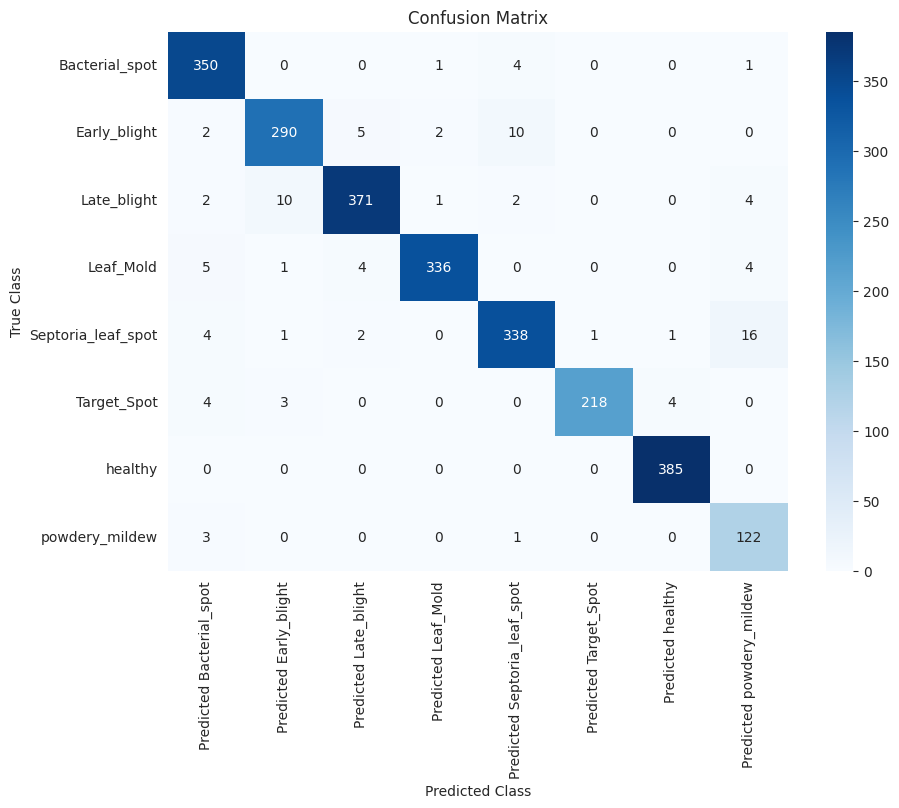


Classification Report:

                    precision    recall  f1-score   support

    Bacterial_spot     0.9459    0.9831    0.9642       356
      Early_blight     0.9508    0.9385    0.9446       309
       Late_blight     0.9712    0.9513    0.9611       390
         Leaf_Mold     0.9882    0.9600    0.9739       350
Septoria_leaf_spot     0.9521    0.9311    0.9415       363
       Target_Spot     0.9954    0.9520    0.9732       229
           healthy     0.9872    1.0000    0.9935       385
    powdery_mildew     0.8299    0.9683    0.8938       126

          accuracy                         0.9609      2508
         macro avg     0.9526    0.9605    0.9557      2508
      weighted avg     0.9623    0.9609    0.9612      2508



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Reset generator agar prediksi dimulai dari awal
test_generator.reset()

# prediksi model
preds_1 = model_2.predict(test_generator, verbose=0)

# Ambil prediksi kelas
predicted_classes = np.argmax(preds_1, axis=1)

# Label ground truth dari generator
true_classes = test_generator.classes

# Nama kelas (harus sesuai urutan class_indices dari generator)
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_df = pd.DataFrame(cm, index=class_labels, columns=[f'Predicted {label}' for label in class_labels])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

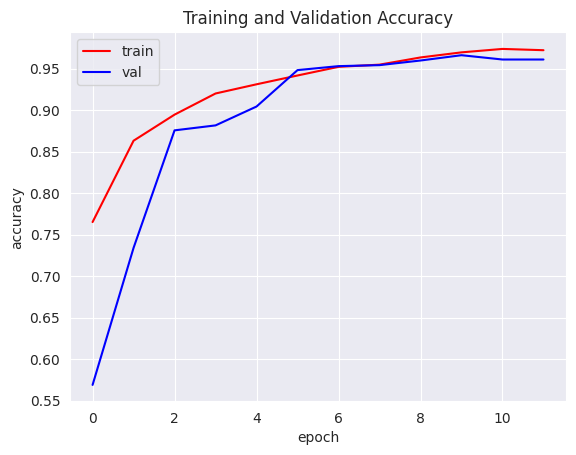

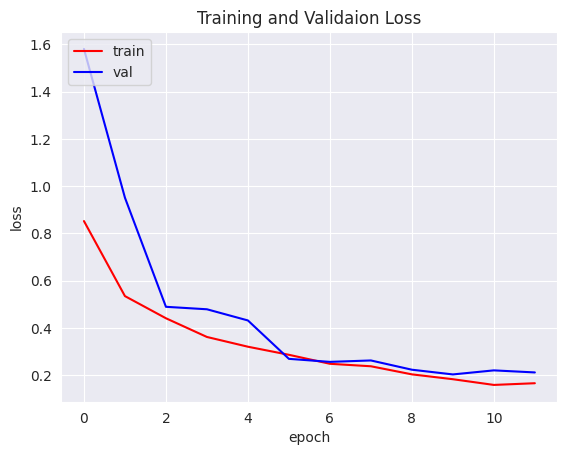

In [ ]:
acc = history_fine_tune.history['accuracy']
val_acc = history_fine_tune.history['val_accuracy']
loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()


## Konversi Model

### SaveModel

In [ ]:
save_path = 'mymodel/'
tf.saved_model.save(model_2, save_path)

###Format tf.js

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/mymodel/ \
    /content/modeltfjs

2025-05-20 07:54:37.766743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747727677.820601   19904 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747727677.835580   19904 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-20 07:54:51.916470: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747727691.916686   19904 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

### Format tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("mymodel")
tflite_model = converter.convert()

with tf.io.gfile.GFile('tomato_disease.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
model_2.save("tanamind_tomato.h5")

In [ ]:
from google.colab import files
files.download('tanamind_tomato.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

2508/2508 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step


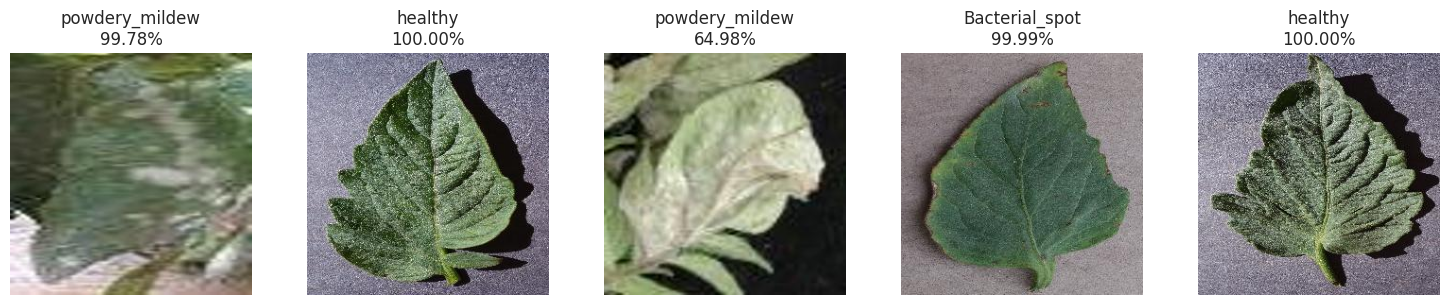

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random

# Ambil probabilitas prediksi dari model
probabilities = model_2.predict(test_generator, verbose=1)

# Ambil label kelas dari generator
class_labels = list(test_generator.class_indices.keys())

# Pilih 5 gambar acak dari dataset
random_indices = random.sample(range(len(test_generator.filenames)), 5)

# Atur layout gambar dalam 1 baris
plt.figure(figsize=(15, 3))

for i, index in enumerate(random_indices):
    probability = probabilities[index]
    image_path = os.path.join(TEST_DIR, test_generator.filenames[index])
    img = mpimg.imread(image_path)

    # Prediksi dan ambil label dengan probabilitas tertinggi
    predicted_class_index = np.argmax(probability)
    confidence = probability[predicted_class_index] * 100
    predicted_label = class_labels[predicted_class_index]

    # Tampilkan gambar dengan judul prediksi
    plt.subplot(1, 5, i+1)  # 1 baris, 5 kolom, gambar ke-i
    plt.imshow(img)
    plt.axis('off')  # Matikan axis
    plt.title(f"{predicted_label}\n{confidence:.2f}%")

plt.tight_layout()  # Mengatur layout agar gambar tidak bertumpuk
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


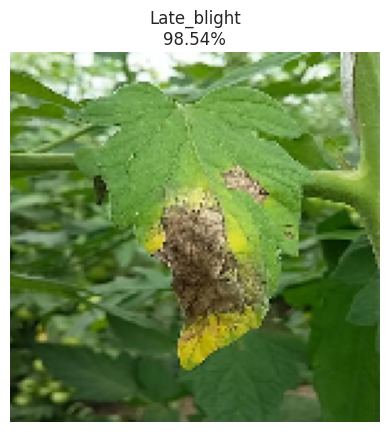

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Ganti dengan path file gambar lokal
image_path = 'test.jpg'

# Load dan praproses gambar
img = image.load_img(image_path, target_size=(150, 150))  # sesuaikan ukuran input model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # tambah dimensi batch
img_array = img_array / 255.0  # normalisasi jika diperlukan

# Lakukan prediksi
prediction = model_2.predict(img_array)

# Ambil label kelas
class_labels = list(test_generator.class_indices.keys())

# Dapatkan hasil prediksi
predicted_index = np.argmax(prediction[0])
predicted_label = class_labels[predicted_index]
confidence = prediction[0][predicted_index] * 100

# Tampilkan gambar dan hasil prediksi
plt.imshow(img)
plt.axis('off')
plt.title(f"{predicted_label}\n{confidence:.2f}%")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


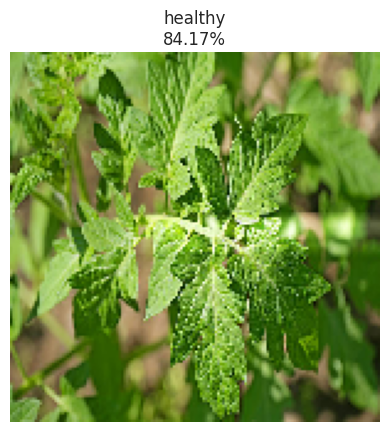

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Ganti dengan path file gambar lokal
image_path = 'sehat.jpg'

# Load dan praproses gambar
img = image.load_img(image_path, target_size=(150, 150))  # sesuaikan ukuran input model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # tambah dimensi batch
img_array = img_array / 255.0  # normalisasi jika diperlukan

# Lakukan prediksi
prediction = model_2.predict(img_array)

# Ambil label kelas
class_labels = list(test_generator.class_indices.keys())

# Dapatkan hasil prediksi
predicted_index = np.argmax(prediction[0])
predicted_label = class_labels[predicted_index]
confidence = prediction[0][predicted_index] * 100

# Tampilkan gambar dan hasil prediksi
plt.imshow(img)
plt.axis('off')
plt.title(f"{predicted_label}\n{confidence:.2f}%")
plt.show()